In [15]:
import cv2
import skimage.io as io
import numpy as np
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin
from scipy.signal import convolve2d
from statistics import mode,variance
from math import sqrt
from skimage.measure import find_contours
import matplotlib.pyplot as plt 
from skimage import data, color, img_as_ubyte 
from skimage.feature import canny 
from skimage.measure import label, regionprops
from skimage.transform import hough_ellipse 
from skimage.draw import ellipse_perimeter 
from skimage.draw import rectangle
from skimage.morphology import disk ,area_opening ,ball,closing
from skimage.morphology import rectangle as rec
from scipy.spatial.distance import euclidean
maxSpace=16

In [4]:
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show() 

In [25]:
def verticalProj(img):
    imgTmp=np.ones((img.shape[0],img.shape[1]+4))
    imgTmp[:,2:imgTmp.shape[1]-2]=img
    img=imgTmp
    proj = np.sum(img,0)
    maxProjection = np.max(proj) 
    result = np.zeros(img.shape) 
    #Draw a line for each row 
    for col in range(img.shape[1]):
        result[0:int(proj[col]),col]=1 
    cv2.imwrite("outs/74.png",result*255)
    return result,maxProjection
def calcVerticalLinesPos(colHist,maxProjection):
    n,m=colHist.shape
    thres=int(maxProjection*0.5)
    start=end=0
    width=[]
    peaksMid=[]
    for i in range(m-1):
        if(colHist[thres][i]!=colHist[thres][i+1]):
            if colHist[thres][i]==1:
                #end of zeros
                start=i
            else:
                #end of ones
                end=i+1
                #if(end-start<1.5*maxSpace):
                peaksMid.append(int((start+end)/2))
                width.append((end-start))
    
    return np.array(width),np.array(peaksMid)




In [26]:
def removeVerticalLines(imgOriginal,midPoint,curWidth):
    thresPixel=curWidth
    curWidth=int(curWidth/2)+1
    errorThres=2
    for i in range(imgOriginal.shape[0]):
        #print(imgOriginal[i:i+1,midPoint-curWidth:midPoint+curWidth])
        pixelSum= imgOriginal[i:i+1,midPoint-curWidth:midPoint+curWidth].sum()
        pixelSum=(curWidth+1)-pixelSum
        #print(pixelSum)
        if(pixelSum<=thresPixel):
            #print(imgOriginal[i:i+1,midPoint-curWidth:midPoint+curWidth])
            imgOriginal[i:i+1,midPoint-curWidth:midPoint+curWidth]=1
    return imgOriginal
def applyRemoving(width,peaksMids,img):
    for i in range(len(peaksMids)):
        img=removeVerticalLines(img,peaksMids[i],width[i])
    return img
        

In [27]:
def removeSymbolVerticalLines(contour):
    Binarized=contour
    result,maxProjection=verticalProj(Binarized)
    cv2.imwrite("outs/res.png",result*255)
    #print(maxProjection)
    width,peaksMids=calcVerticalLinesPos(result,maxProjection)
    #print(width,peaksMids)
    removedImg=applyRemoving(width,peaksMids,Binarized)
    cv2.imwrite("outs/removed.png",removedImg*255)
    return removedImg

In [90]:
def RemoveHorizontalAndDiagonalLines(img):
    tImg = np.copy(img)
    removed = np.copy(img)
    labelImg = label(tImg)
    regions = regionprops(labelImg)
    for r in regions:
        minr, minc, maxr, maxc = r.bbox
        aspectratio = (maxc-minc)/(maxr-minr)
        if(aspectratio >= 1.5):
            diagonal.append([minr, minc, maxr, maxc])
            removed[minr:maxr,minc:maxc]=0
            bx = (minc, maxc, maxc, minc, minc)
            by = (minr, minr, maxr, maxr, minr)
            y0,x0 = r.centroid
            ax.plot(bx, by, '-b', linewidth=2.5)
            ax.plot(x0, y0, '.g', markersize=15)
            '''
            print("area : ",r.area)
            print("bounding box :" , r.bbox)
            print("width = " ,maxc-minc)
            print("height = ",maxr-minr)
            print("aspect ratio = ",((maxc-minc)/(maxr-minr)) )
            '''
    return removed
    
        

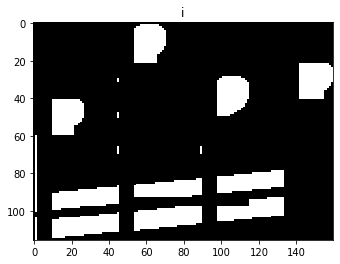

58


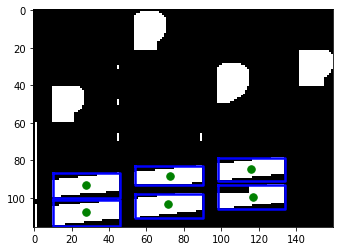

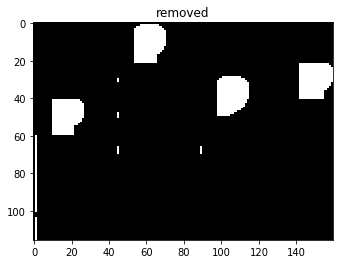

In [130]:
img2=cv2.imread("contours/49.png",0)
img2=img2>100
img2=img2*1
removeSymbolVerticalLines(img2)
show_images([1-img2],["i"])

removed = RemoveHorizontalAndDiagonalLines(1-img2)
show_images([removed],["removed"])

In [89]:
import matplotlib.pyplot as plt
from skimage import data, color, img_as_ubyte
from skimage.feature import canny
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter
import skimage.measure as measure
def testBlob(blob,index):
    width=blob.bbox[3]-blob.bbox[1]
    height=blob.bbox[2]-blob.bbox[0]
    print(width,height)
    minEccentricity=.2
    maxEccentricity=.9
    minArea=1.1*(maxSpace**2)
    maxArea=4*(maxSpace**2)
    minMajorAxis=maxSpace
    maxMajorAxis=3.2*maxSpace
    minMinorAxis=.5*maxSpace
    maxMinorAxis=2*maxSpace
    minSolidity=.85
    if( blob.solidity>=minSolidity and blob.area>minArea and blob.area<maxArea and blob.eccentricity <maxEccentricity and width>minMajorAxis and width<maxMajorAxis and height>minMinorAxis and height<maxMinorAxis):
        return True
    return False

def detectBlackBlob(symbol,index):
    labels = measure.label(symbol)
    props = measure.regionprops(labels)
    isBlob=False
    numBlobs=0
    for prop in props:
        isBlob=testBlob(prop,index)
        if(isBlob):
            numBlobs=numBlobs+1
    for prop in props:
        print(index,prop.area,prop.eccentricity,prop.major_axis_length,prop.minor_axis_length,prop.solidity)

    if(numBlobs>0):
        cv2.imwrite("blobs/"+str(index)+"_"+str(numBlobs)+".png",symbol*255)



In [67]:
img2=cv2.imread("outing.png",0)
img2=img2>100
img2=img2*1
contours = find_contours(img2, 0.8)
imgContours=[]
imgSymbolsContours=[]
index=0
for contour in contours:
    x = contour[:,1]
    y = contour[:,0]
    [Xmin, Xmax, Ymin, Ymax] = [np.amin(x), np.amax(x), np.amin(y), np.amax(y)]
    rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=img2.shape)
    imgSymbol=img2[int(Ymin):int(Ymax+1),int(Xmin):int(Xmax+1)]
    imgContours.append([Ymin,Xmin])
    imgSymbol=removeSymbolVerticalLines(imgSymbol)
    imgSymbolsContours.append(1-imgSymbol)
    cv2.imwrite("contours/"+str(index)+".png",imgSymbol*255)
    index+=1
imgSymbolsContours=np.array(imgSymbolsContours)
imgContours=np.array(imgContours)

92.0
[6] [26]
[[1 1 1 1 1 1 1 1]]
[[0 0 0 0 0 1 1 1]]
[[0 0 0 0 0 1 1 1]]
[[0 0 0 0 0 1 1 1]]
[[0 0 0 0 0 1 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 0 1]]
[[0 0 0 0 0 0 0 1]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 1 0 0]]
[[0 0 0 0 0 1 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 0 1]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 1 0 0]]
[[0 0 0 0 0 1 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 0 1]]
[[0 0 0 0 0 0 0 1]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 1 1 0]]
[[0 0 0 0 0 1 1 0]]
[[0 0 0 0 0 1 1 0]]
[[0 0 0 0 0 1 1 0]]
[[0 0 0 0 0 1 1 0]]
[[0 0 0 0 0 1 1 1]]
[[0 0 0 0 0 1 1 1]]
[[0 0 0 0 0 1 1 1]]
[[0 0 0 0 0 1 1 1]]
[[0 0 

[[0 0 0 1 1 1 1 1]]
[[0 0 1 1 1 1 1 1]]
[[0 1 1 1 1 1 1 1]]
[[1 1 1 1 1 1 1 1]]
[[1 1 1 1 1 1 1 1]]
[[1 1 1 1 1 1 1 1]]
[[1 1 1 1 1 1 1 1]]
[[1 1 1 1 1 1 1 1]]
[[1 1 1 1 1 1 1 1]]
[[1 1 1 1 1 1 1 1]]
[[1 1 1 1 1 1 1 1]]
[[1 1 1 1 1 1 1 1]]
[[1 1 1 1 1 1 1 1]]
[[1 1 1 1 1 1 1 1]]
[[1 1 1 1 1 1 1 1]]
[[1 1 1 1 1 1 1 0]]
[[1 1 1 1 1 0 0 0]]
[[1 1 1 1 0 0 0 0]]
[[1 1 1 0 0 0 0 0]]
[[1 1 0 0 0 0 0 0]]
[[1 1 0 0 0 0 0 0]]
[[1 0 0 0 0 0 0 0]]
[[1 0 0 0 0 0 0 0]]
[[1 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[1 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 1 1 1]]
[[0 0 0 0 0 1 1 1]]
[[0 0 0 0 0 1 1 1]]
[[0 0 0 0 0 1 1 1]]
[[0 0 0 0 0 1 1 1]]
[[0 0 0 0 0 1 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 1 1 1]]
[[0 0 0 0 0 1 1 1]]
[[0 0 0 0 0 1 1 1]]
[[0 0 0 0 0 1 1 1]]
[[0 0 0 0 0 1 1 1]]
[[0 0 0 0 0 1 1 1]]


[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 

[[1 1 1 1 1 1 1 1 1 1 1 1]]
[[1 1 1 1 0 0 0 0 0 1 1 1]]
[[1 0 0 0 0 0 0 0 0 1 1 1]]
[[1 0 0 0 0 0 0 0 1 1 1 1]]
[[1 0 0 0 0 0 0 1 1 1 1 1]]
[[1 0 0 0 0 0 1 1 1 1 1 1]]
[[1 0 0 0 0 0 1 1 1 1 1 1]]
[[1 0 0 0 0 1 1 0 0 0 0 1]]
[[1 0 0 0 1 1 0 0 0 0 0 1]]
[[1 0 0 1 1 0 0 0 0 0 1 1]]
[[1 0 1 1 0 0 0 0 0 0 1 1]]
[[1 1 1 0 0 0 0 0 0 0 1 1]]
[[1 1 0 0 0 0 0 0 0 0 1 1]]
[[1 1 0 0 0 0 0 0 0 0 1 1]]
[[1 0 0 0 0 0 0 0 0 0 1 1]]
[[1 0 0 0 0 0 0 0 0 0 1 1]]
[[1 0 0 0 0 0 0 0 0 0 1 1]]
[[1 0 0 0 0 0 0 0 0 0 1 1]]
[[1 0 0 0 0 0 0 0 0 0 1 1]]
[[1 0 0 0 0 0 0 0 0 0 1 1]]
[[1 0 0 0 0 0 0 0 0 0 1 1]]
[[1 0 0 0 0 0 0 0 0 0 1 1]]
[[1 0 0 0 0 0 0 0 0 0 0 0]]
[[1 0 0 0 0 0 0 0 0 0 0 0]]
[[1 0 0 0 0 0 0 0 0 0 0 0]]
[[1 0 0 0 0 0 0 0 0 0 1 1]]
[[1 0 0 0 0 0 0 0 0 0 1 1]]
[[1 0 0 0 0 0 0 0 0 0 1 1]]
[[1 0 0 0 0 0 0 0 0 0 1 1]]
[[1 0 0 0 0 0 0 0 0 0 1 1]]
[[1 0 0 0 0 0 0 0 0 0 0 1]]
[[1 0 0 0 0 0 0 0 0 0 0 1]]
19.0
[3 2] [12 15]
[[1 1 1 1]]
[[1 1 1 1]]
[[1 1 1 1]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[[0 0 0 0]]
[

3.0
[] []
2.0
[] []
19.0
[4 6] [ 7 14]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[1 0 0 0 0 0]]
[[1 1 0 0 0 0]]
[[1 1 1 0 0 0]]
[[1 1 1 1 0 0]]
[[1 1 1 1 1 0]]
[[1 1 1 1 1 1]]
[[1 1 1 1 1 1]]
[[0 1 1 1 1 1]]
[[0 0 0 1 1 1]]
[[0 0 0 1 1 1]]
[[0 0 0 1 1 1]]
[[0 0 0 1 1 1]]
[[0 0 0 1 1 1]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 1 1 1]]
[[0 0 0 1 1]]
[[0 0 0 0 1]]
[[0 0 0 0 1]]
[[0 0 0 0 0]]
[[0 0 0 0 0]]
[[0 0 0 0 0]]
[[0 0 0 0 0]]
[[0 0 0 0 0]]
[[1 1 0 0 0]]
[[1 1 0 0 0]]
[[1 1 0 0 0]]
[[1 1 0 0 0]]
[[1 1 0 0 0]]
[[1 1 1 1 0]]
[[1 1 1 1 0]]
[[0 0 1 1 0]]
[[0 0 0 1 1]]
[[0 0 0 0 1]]
79.0
[6] [34]
[[1 1 1 1 1 1 1 1]]
[[0 0 0 0 0 1 1 1]]
[[0 0 0 0 0 1 1 1]]
[[0 0 0 0 0 1 1 1]]
[[0 0 0 0 0 1 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 0 1]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0

108.0
[7] [25]
[[1 1 1 1 1 1 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[0 0 0 0 0 0 1 1]]
[[1 0 0 0 0 0 1 1]]
[[1 0 0 0 0 0 1 1]]
[[1 0 0 0 0 0 1 1]]
[[1 0 0 0 0 0 1 1]]
[[1 0 0 0 0 0 1 1]]
[[1 0

[[1 1 1 1 1 1]]
[[1 1 1 1 1 1]]
[[1 1 1 1 1 1]]
[[1 1 1 1 1 1]]
[[1 1 1 1 1 1]]
[[1 1 1 1 1 1]]
[[1 1 1 1 1 1]]
[[1 1 1 1 1 1]]
[[1 1 1 1 1 1]]
[[1 1 1 1 1 1]]
[[1 1 1 1 1 1]]
[[1 1 1 1 1 1]]
[[1 1 1 1 1 1]]
[[1 1 1 1 1 1]]
[[1 1 1 1 1 1]]
[[1 1 1 1 1 1]]
[[1 1 1 1 1 1]]
[[1 1 1 1 1 1]]
[[1 1 1 1 1 1]]
[[1 1 1 1 1 1]]
[[1 1 1 1 1 1]]
[[1 1 1 1 1 1]]
[[1 1 1 1 1 1]]
[[1 1 1 1 1 1]]
[[1 1 1 1 1 1]]
[[1 1 1 1 1 1]]
[[0 0 0 0 0 1]]
[[0 0 0 0 0 1]]
[[0 0 0 0 0 1]]
[[0 0 0 0 0 1]]
[[0 0 0 0 0 1]]
[[0 0 0 0 0 1]]
[[0 0 0 0 0 1]]
[[0 0 0 0 0 1]]
[[0 0 0 0 0 1]]
[[0 0 0 0 0 1]]
[[0 0 0 0 0 1]]
[[0 0 0 0 0 1]]
[[0 0 0 0 0 1]]
[[0 0 0 0 0 1]]
[[0 0 0 0 0 1]]
[[0 0 0 0 0 1]]
[[0 0 0 0 0 1]]
[[0 0 0 0 0 1]]
[[0 0 0 0 0 1]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 1]]
[[0 0 0 0 0 1]]
[[0 0 0 0 0 1]]
[[0 0 0 0 0 1]]
[[0 0 0 0 0 1]]
[[0 0 0 0 0 1]]
[[0 0 0 0 0 1]]
[[0 0 0 0 0 1]]
[[0 0 0 0 0 1]]
[[0 0 0 0 0 1]]
[[0 0 0 0 0 1]]
[[0 0 0 0 0 1]]
[[0 0 0 0 0 1]]
[[0 0 0 0 0 1]]
[[0 0 0 

[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 1 1 1]]
[[0 0 0 1 1 1]]
[[0 0 0 0 1 1]]
[[0 0 0 0 1 1]]
[[0 0 0 0 1 1]]
[[0 0 0 0 1 1]]
[[0 0 0 0 1 1]]
[[0 0 0 0 1 1]]
[[0 0 0 0 1 1]]
[[0 0 0 0 1 1]]
[[0 0 0 0 1 1]]
[[0 0 0 0 1 1]]
[[0 0 0 0 1 1]]
[[0 0 0 0 1 1]]
[[0 0 0 0 1 1]]
[[0 0 0 0 1 1]]
[[0 0 0 0 1 1]]
[[0 0 0 0 1 1]]
[[0 0 0 0 1 1]]
[[0 0 0 0 1 1]]
[[0 0 0 0 1 1]]
[[0 0 0 0 1 1]]
[[0 0 0 0 1 1]]
[[0 0 0 0 1 1]]
[[0 0 0 0 1 1]]
[[0 0 0 0 1 1]]
[[0 0 0 0 1 1]]
[[0 0 0 0 1 1]]
[[0 0 0 0 1 1]]
[[0 0 0 0 1 1]]
[[0 0 0 1 1 1]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 1 1]]
[[0 0 0 1 1 1]]
[[0 0 0 1 1 1]]
[[0 0 0 1 1 1]]
[[0 0 0 1 1 1]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[1 1 1 1 1 1 1 1]]
[[1 1 1 1 1 1 1 1]]


[7] [5]
[[1 1 1 1 1 1]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]


60.0
[6 6] [ 8 15]
[[1 1 1 1 1 1 1 1]]
[[1 1 1 1 1 1 1 0]]
[[1 1 1 1 1 1 1 0]]
[[0 0 0 0 1 1 1 0]]
[[0 0 0 0 0 1 1 0]]
[[0 0 0 0 0 1 1 0]]
[[0 0 0 0 0 1 1 0]]
[[0 0 0 0 0 1 1 0]]
[[0 0 0 0 0 1 1 0]]
[[0 0 0 0 0 1 1 0]]
[[0 0 0 0 0 1 1 0]]
[[0 0 0 0 0 1 1 0]]
[[0 0 0 0 0 1 1 0]]
[[0 0 0 0 0 1 1 0]]
[[0 0 0 0 0 1 1 0]]
[[0 0 0 0 0 1 1 0]]
[[0 0 0 0 0 1 1 1]]
[[0 0 0 0 0 1 0 0]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 1 1 0]]
[[0 0 0 0 0 1 1 1]]
[[0 0 0 0 0 1 1 0]]
[[0 0 0 0 0 1 1 0]]
[[0 0 0 0 0 1 1 0]]
[[0 0 0 0 0 1 1 0]]
[[0 0 0 0 0 1 1 0]]
[[0 0 0 0 0 1 1 0]]
[[0 0 0 0 0 1 1 1]]
[[0 0 0 0 1 1 1 0]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 1]]
[[0 0 0 0 1 1 1 0]]
[[0 0 0 0 0 1 1 0]]
[[0 0 0 0 0 1 1 0]]
[[0 0 0 0 0 1 1 0]]
[

[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 1]]
[[0 0 0 1 1 1]]
[[0 0 0 1 1 0]]
[[0 0 0 1 1 0]]
[[0 0 0 1 1 0]]
[[0 0 0 1 1 0]]
[[1 1 1 1 1 0]]
[[1 1 1 1 1 0]]
[[1 1 1 1 1 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[1 1 1 1 1 0]]
[[1 1 1 1 1 0]]
[[1 1 1 1 1 0]]
[[1 1 1 1 0 0]]
[[1 1 1 1 0 0]]
[[1 1 1 0 0 0]]
[[1 0 0 0 0 0]]
[[1 0 0 0 0 0]]
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
[[1 1 1 1 1 0 0 0 0 0 1 1 1 1]]
[[1 1 0 0 0 0 0 0 0 0 1 1 1 1]]
[[1 1 0 0 0 0 0 0 0 1 1 1 1 1]]
[[1 1 0 0 0 0 0 0 1 1 1 1 1 1]]
[[1 1 0 0 0 0 0 1 1 1 1 1 1 1]]
[[1 1 0 0 0 0 0 1 1 1 1 1 1 1]]
[[1 1 0 0 0 0 1 1 0 0 0 0 1 1]]
[[1 1 0 0 0 1 1 0 0 0 0 0 1 1]]
[[1 1 0 0 1 1 0 0 0 0 0 1 1 1]]
[[1 1 0 1 1 0 0 0 0 0 0 1 1 1]]
[[1 1 1 1 0 0 0 0 0 0 0 1 1 1]]
[[1 1 1 0 0 0 0 0 0 0 0 1 1 1]]
[[1 1 1 0 0 0 0 0 0 0 0 1 1 1]]
[[1 1 0 0 0 0 0 0 0 0 0 1 1 1]]
[[1 1 0 0 0 0 0 0 0 0 0 

[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 1]]
[[0 0 0 1 1 1]]
[[0 0 0 1 1 0]]
[[0 0 0 1 1 0]]
[[0 0 0 1 1 0]]
[[0 0 0 1 1 0]]
[[1 1 1 1 1 0]]
[[1 1 1 1 1 0]]
[[1 1 1 1 1 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[0 0 0 0 0 0]]
[[1 1 1 1 1 0]]
[[1 1 1 1 1 0]]
[[1 1 1 1 1 0]]
[[1 1 1 1 0 0]]
[[1 1 1 1 0 0]]
[[1 1 1 0 0 0]]
[[1 0 0 0 0 0]]
[[1 0 0 0 0 0]]
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1]]
[[1 1 1 1 1 0 0 0 0 0 1 1 1 1]]
[[1 1 0 0 0 0 0 0 0 0 1 1 1 1]]
[[1 1 0 0 0 0 0 0 0 1 1 1 1 1]]
[[1 1 0 0 0 0 0 0 1 1 1 1 1 1]]
[[1 1 0 0 0 0 0 1 1 1 1 1 1 1]]
[[1 1 0 0 0 0 0 1 1 1 1 1 1 1]]
[[1 1 0 0 0 0 1 1 0 0 0 0 1 1]]
[[1 1 0 0 0 1 1 0 0 0 0 0 1 1]]
[[1 1 0 0 1 1 0 0 0 0 0 1 1 1]]
[[1 1 0 1 1 0 0 0 0 0 0 1 1 1]]
[[1 1 1 1 0 0 0 0 0 0 0 1 1 1]]
[[1 1 1 0 0 0 0 0 0 0 0 1 1 1]]
[[1 1 1 0 0 0 0 0 0 0 0 1 1 1]]
[[1 1 0 0 0 0 0 0 0 0 0 1 1 1]]
[[1 1 0 0 0 0 0 0 0 0 0 1 1 1]]
[[1 1 0 0 0 0 0 0 0 0 0 1 1 1]]
[[1 1 0 0 0 0 0 0 0 0 0 1 1 1]]
[[1 1 0 

In [68]:
ind=0
for cont in imgSymbolsContours:
    detectBlackBlob(cont,ind)
    ind+=1

16 64
21 21
0 510 0.97347002393408 63.68079432120018 14.571094273633314 0.6864064602960969
0 367 0.573133540591136 24.068039100402128 19.722843093179375 0.976063829787234
23 130
2 16
17 55
3 18
4 4
7 20
1 1063 0.9877727420207811 141.1289320259988 22.0020910826133 0.4643949322848405
1 24 0.9929946598121048 15.95827893811443 1.8856180831641234 0.8888888888888888
1 457 0.9548707404320159 59.60970889085187 17.705374943527648 0.6356050069541029
1 43 0.9842724357219604 17.77842147901225 3.1406864591112096 0.9347826086956522
1 14 0.6072856123196266 4.74024689744533 3.7660484032669737 0.9333333333333333
1 106 0.9214488157825259 19.316497701554066 7.504455128131265 0.9814814814814815
8 4
8 14
2 17 0.9435800689942653 10.71690593589489 3.548844029143553 0.6071428571428571
2 56 0.8879240069328723 14.10899049985824 6.489996960268752 0.835820895522388
20 40
3 689 0.8823601701215654 44.7395837104869 21.05331532240471 0.9285714285714286
10 8
16 64
7 10
21 21
5 45 0.8572037863001783 11.606808131905707 

6 32
2 15
3 4
4 6
62 43 0.9529584563305726 13.578972067068653 4.115799212975683 0.9555555555555556
62 126 0.9857958980695027 32.34162340031673 5.431702941057782 0.8289473684210527
62 25 0.9917593847235369 15.263554247153452 1.955482483737402 0.9259259259259259
62 11 0.7084437526351622 4.346129984141888 3.067356324605906 1.0
62 18 0.7954694556792927 6.29176128210429 3.81276759836432 1.0
9 20
1 3
1 2
63 84 0.9297874352291504 20.513505315297653 7.550957645044726 0.7241379310344828
63 3 1.0 3.265986323710904 0.0 1.0
63 2 1.0 2.0 0.0 1.0
1 13
4 12
4 7
67 13 1.0 14.966629547095765 0.0 1.0
67 30 0.9463249749722364 12.062745864545967 3.8988810341545803 0.8333333333333334
67 14 0.9266488956684161 7.901963450509369 2.970568926866209 0.7368421052631579
18 4
6 2
6 1
6 6
6 4
70 63 0.9807269245855911 20.611083461099145 4.02706495664615 0.9402985074626866
70 12 0.9561828874675149 6.831300510639732 2.0 1.0
70 6 1.0 6.831300510639732 0.0 1.0
70 31 0.548823399637955 7.021211807061975 5.869300007253828 0